<a href="https://colab.research.google.com/github/kimhwijin/computer_vision_assignment/blob/main/Project2/UWMGI_Infer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/kimhwijin/computer_vision_assignment.git
!pip install -q albumentations
!pip install -q segmentation_models_pytorch
!pip install "opencv-python-headless<4.3"
!pip install colorama
!curl https://colab.chainer.org/install | sh -
!pip install -q cucim
!pip install -q scipy scikit-image cupy-cuda100

Cloning into 'computer_vision_assignment'...
remote: Enumerating objects: 532, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 532 (delta 122), reused 159 (delta 74), pack-reused 314
Receiving objects: 100% (532/532), 8.60 MiB | 5.00 MiB/s, done.
Resolving deltas: 100% (250/250), done.
     |████████████████████████████████| 631 kB 14.8 MB/s 
     |████████████████████████████████| 88 kB 5.2 MB/s 
     |████████████████████████████████| 376 kB 26.0 MB/s 
     |████████████████████████████████| 58 kB 6.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.6 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed


In [2]:
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!unzip -q /content/drive/MyDrive/Dataset/UWMGI/uw-madison-gi-tract-image-segmentation.zip

In [4]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os
from tqdm import tqdm
tqdm.pandas()
import time
from collections import defaultdict
import gc

# visualization
import cv2
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torch.nn.functional as F

import timm

# Albumentations for augmentations
import albumentations as A

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
class CFG:
    seed = 101
    debug = False

    # model
    comment = 'unet-efficientnet_b1-224x224'
    model_name = 'Unet'
    backbone = 'efficientnet-b1'
    
    # Data
    n_fold = 7
    n_classes = 3
    train_batch_size = 64
    valid_batch_size = 64
    img_size = [224,224]

    # train
    n_accumulate  = max(1, 32//train_batch_size)
    epochs = 15

    # scheduler
    scheduler = 'cos'
    learning_rate = 1e-3
    min_learning_rate = 1e-6
    T_max = int(30000/train_batch_size*epochs)+50
    T_0 = 25
    warmup_epochs = 0
    weight_decay = 1e-6

    #
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    threshold = 0.5

In [6]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
set_seed(CFG.seed)

> SEEDING DONE


In [7]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
    img = img.astype('float32') # original is uint16
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img

def load_msk(path):
    msk = np.load(path)
    msk = msk.astype('float32')
    msk/=255.0
    return msk

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

In [8]:
def __split_case_id_and_add_column(df : pd.DataFrame) -> pd.DataFrame:
    df["case_id_str"] = df["id"].apply(lambda x : x.split("_", 2)[0])
    df["case_id"] = df["id"].apply(lambda x : int(x.split("_",2)[0].replace("case", "")))
    return df

def __split_day_number_and_add_column(df:pd.DataFrame) -> pd.DataFrame:
    df["day_number_str"] = df["id"].apply(lambda x : x.split("_", 2)[1])
    df["day_number"] = df["id"].apply(lambda x : int(x.split("_", 2)[1].replace("day", "")))
    return df

def __split_slice_id_and_add_column(df:pd.DataFrame) -> pd.DataFrame:
    df["slice_id"] = df["id"].apply(lambda x: x.split("_", 2)[2])
    return df

def __merge_dataframe_with_filepath(df:pd.DataFrame, globbed_full_filepaths:list) ->pd.DataFrame:
    df["_partial_identifier"] = (globbed_full_filepaths[0].rsplit("/", 4)[0] + "/" +
                                    df["case_id_str"] + "/" + 
                                    df["case_id_str"] + "_" + df["day_number_str"] + "/"
                                    "scans/" +
                                    df["slice_id"]
                                )
    
    _merging_df = pd.DataFrame({
        "_partial_identifier" : [x.rsplit("_", 4)[0] for x in globbed_full_filepaths],
        "image_path": globbed_full_filepaths
    })
    df = df.merge(_merging_df, on="_partial_identifier").drop(columns="_partial_identifier")
    return df

def __slice_file_height_and_weight(df:pd.DataFrame)->pd.DataFrame:
    df["slice_height"] = df["image_path"].apply(lambda x : int(x[:-4].rsplit("_", 4)[1]))
    df["slice_width"] = df["image_path"].apply(lambda x : int(x[:-4].rsplit("_", 4)[2]))
    return df

def __slice_pixel_spacing(df:pd.DataFrame)->pd.DataFrame:
    df["pixel_spacing_height"] = df["image_path"].apply(lambda x : float(x[:-4].rsplit("_", 4)[3]))
    df["pixel_spacing_width"] = df["image_path"].apply(lambda x : float(x[:-4].rsplit("_", 4)[4]))
    return df

def __merge_LF_rows_to_single_row_and_multiple_columns(df:pd.DataFrame)->pd.DataFrame:
    large_bowel_df = df[df["class"] == "large_bowel"][['id', 'segmentation']].rename(columns={
        "segmentation": "large_bowel_RLE_encoded"
    })
    small_bowel_df = df[df["class"] == "small_bowel"][["id", "segmentation"]].rename(columns= {
        "segmentation": "small_bowel_RLE_encoded"
    })
    stomach_df = df[df["class"] == "stomach"][["id", "segmentation"]].rename(columns={
        "segmentation": "stomach_RLE_encoded"
    })
    df = df.merge(large_bowel_df, on="id", how="left")
    df = df.merge(small_bowel_df, on="id", how="left")
    df = df.merge(stomach_df, on="id", how="left")
    df = df.drop_duplicates(subset=["id", ]).reset_index(drop=True)

    df["large_bowel_flag"] = df["large_bowel_RLE_encoded"].apply(lambda x : not pd.isna(x))
    df["small_bowel_flag"] = df["small_bowel_RLE_encoded"].apply(lambda x : not pd.isna(x))
    df["stomach_flag"] = df["stomach_RLE_encoded"].apply(lambda x : not pd.isna(x))
    df["n_segs"] = df["large_bowel_flag"].astype(int) + df["small_bowel_flag"].astype(int) + df["stomach_flag"].astype(int)
    
    return df

In [9]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [10]:
df = pd.read_csv('/content/train.csv')
all_train_images = glob(os.path.join('/content/train', "**", "*.png"), recursive=True)
df = __split_case_id_and_add_column(df)
df = __split_day_number_and_add_column(df)
df = __split_slice_id_and_add_column(df)
df = __merge_dataframe_with_filepath(df, all_train_images)
df = __slice_file_height_and_weight(df)
df = __slice_pixel_spacing(df)
df = __merge_LF_rows_to_single_row_and_multiple_columns(df)
df = df.drop(columns=['class', 'segmentation']).fillna('')
df.sample(5)

,id,case_id_str,case_id,day_number_str,day_number,slice_id,image_path,slice_height,slice_width,pixel_spacing_height,pixel_spacing_width,large_bowel_RLE_encoded,small_bowel_RLE_encoded,stomach_RLE_encoded,large_bowel_flag,small_bowel_flag,stomach_flag,n_segs
30425,case18_day19_slice_0074,case18,18,day19,19,slice_0074,/content/train/case18/case18_day19/scans/slice...,360,310,1.5,1.5,34006 11 34361 18 34718 24 35074 31 35433 34 3...,,42698 5 43056 10 43415 13 43728 12 43774 14 44...,True,False,True,2
37005,case2_day5_slice_0094,case2,2,day5,5,slice_0094,/content/train/case2/case2_day5/scans/slice_00...,266,266,1.5,1.5,23761 4 24018 15 24282 17 24547 19 24811 21 25...,19804 5 20068 8 20332 12 20596 14 20862 15 211...,,True,True,False,2
10616,case140_day10_slice_0137,case140,140,day10,10,slice_0137,/content/train/case140/case140_day10/scans/sli...,266,266,1.5,1.5,,,,False,False,False,0
4514,case15_day0_slice_0051,case15,15,day0,0,slice_0051,/content/train/case15/case15_day0/scans/slice_...,266,266,1.5,1.5,,,,False,False,False,0
11015,case134_day0_slice_0104,case134,134,day0,0,slice_0104,/content/train/case134/case134_day0/scans/slic...,360,310,1.5,1.5,51929 4 52286 11 52645 17 53004 21 53363 23 53...,41974 16 42325 34 42682 40 43034 52 43390 59 4...,,True,True,False,2


In [11]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_path  = row['image_path']
        id_ = row['id']
        
        img = load_img(img_path)
        w, h = img.shape[:2]
        data = self.transform(image=img)
        img = data['image']
        mask = np.zeros((w, h, 3), dtype=np.uint8)
        if row['large_bowel_flag']:
            mask[:, :, 0] = rle_decode(row['large_bowel_RLE_encoded'], (w,h))
        if row['small_bowel_flag']:
            mask[:, :, 1] = rle_decode(row['small_bowel_RLE_encoded'], (w,h))
        if row['stomach_flag']:
            mask[:, :, 2] = rle_decode(row['stomach_RLE_encoded'], (w,h))

        img = np.transpose(img, (2, 0, 1))
        return torch.tensor(img), id_, h, w, mask

In [12]:
data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
#         A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=5, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
#         A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
#                          min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),
    
    "valid": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

In [13]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.Unet(
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.n_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [14]:
import cupy as cp

def mask2rle(msk, thr=0.5):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    msk    = cp.array(msk)
    pixels = msk.flatten()
    pad    = cp.array([0])
    pixels = cp.concatenate([pad, pixels, pad])
    runs   = cp.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def masks2rles(msks, ids, heights, widths):
    pred_strings = []; pred_ids = []; pred_classes = [];
    for idx in range(msks.shape[0]):
        height = heights[idx].item()
        width = widths[idx].item()
        msk = cv2.resize(msks[idx], 
                         dsize=(width, height), 
                         interpolation=cv2.INTER_NEAREST) # back to original shape
        rle = [None]*3
        for midx in [0, 1, 2]:
            rle[midx] = mask2rle(msk[...,midx])
        pred_strings.extend(rle)
        pred_ids.extend([ids[idx]]*len(rle))
        pred_classes.extend(['large_bowel', 'small_bowel', 'stomach'])
    return pred_strings, pred_ids, pred_classes

In [15]:
@torch.no_grad()
def infer(model_paths, test_loader, num_log=1, thr=CFG.threshold):
    msks = []; imgs = [];
    pred_strings = []; pred_ids = []; pred_classes = [];
    for idx, (img, ids, heights, widths, masks) in enumerate(tqdm(test_loader, total=len(test_loader), desc='Infer ')):
        img = img.to(CFG.device, dtype=torch.float) # .squeeze(0)
        size = img.size()
        msk = []
        msk = torch.zeros((size[0], 3, size[2], size[3]), device=CFG.device, dtype=torch.float32)
        for path in model_paths:
            model = load_model(path)
            out   = model(img) # .squeeze(0) # removing batch axis
            out   = nn.Sigmoid()(out) # removing channel axis
            msk+=out/len(model_paths)
        msk = (msk.permute((0,2,3,1))>thr).to(torch.uint8).cpu().detach().numpy() # shape: (n, h, w, c)
        result = masks2rles(msk, ids, heights, widths)
        pred_strings.extend(result[0])
        pred_ids.extend(result[1])
        pred_classes.extend(result[2])
        if idx<num_log:
            img = img.permute((0,2,3,1)).cpu().detach().numpy()
            imgs.append(img[:10])
            msks.append(msk[:10])
        del img, msk, out, model, result
        gc.collect()
        torch.cuda.empty_cache()
    return pred_strings, pred_ids, pred_classes, imgs, msks

In [16]:
test_dataset = BuildDataset(df, data_transforms['valid'])
test_loader  = DataLoader(test_dataset, shuffle=True)
model_path  = '/content/drive/MyDrive/kaggle/UWMGI/model/best_epoch-00.bin'
model = load_model(model_path)

In [17]:
tl = iter(test_loader)

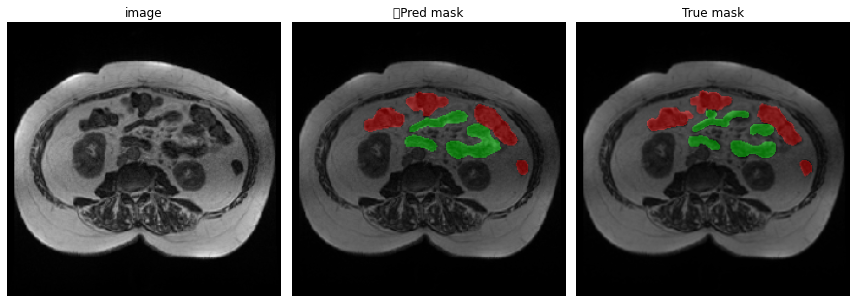

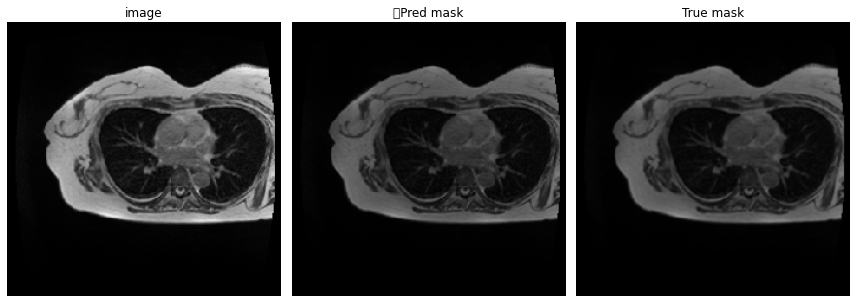

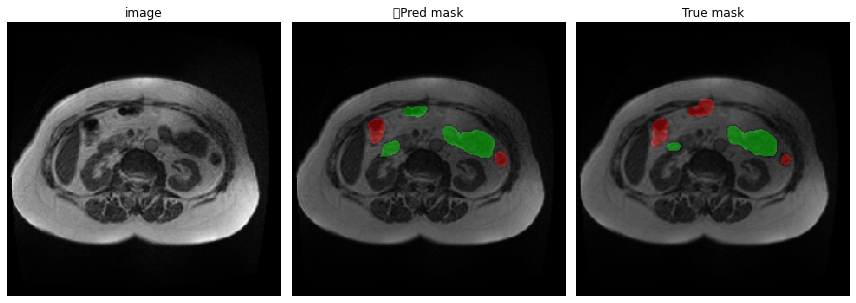

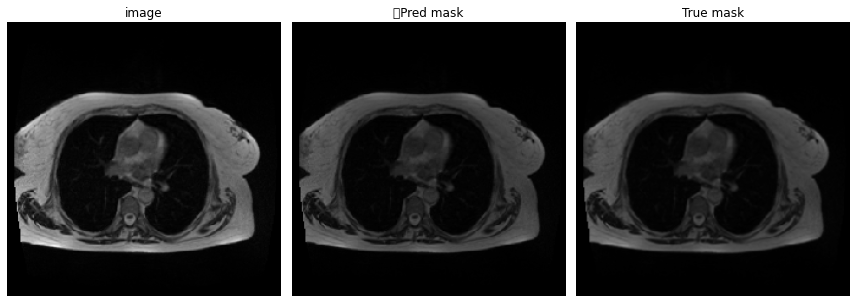

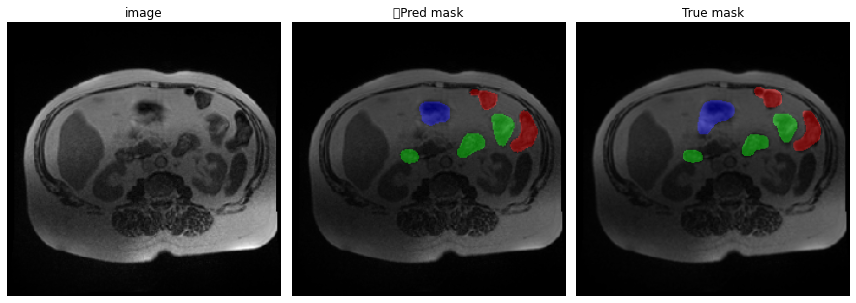

In [18]:
for _ in range(5):
    img, id_, h, w, mask = next(tl)
    img = img.to(CFG.device)
    out = model(img)
    out = nn.Sigmoid()(out)

    img = img.permute(0,2,3,1).cpu().detach().numpy()[0]
    pred_mask = (out.permute((0,2,3,1))>CFG.threshold).to(torch.uint8).cpu().detach().numpy()[0]
    mask = mask[0]

    plt.figure(figsize=(12, 7))
    plt.subplot(1, 3, 1); plt.imshow(img, cmap='bone');
    plt.axis('OFF'); plt.title('image')

    plt.subplot(1, 3, 2); plt.imshow(img, cmap='bone'); plt.imshow(pred_mask*255, alpha=0.4);
    plt.axis('OFF'); plt.title('Pred mask')

    plt.subplot(1, 3, 3); plt.imshow(cv2.resize(img, (h.item(),w.item())), cmap='bone'); plt.imshow(mask*255, alpha=0.4);
    plt.axis('OFF'); plt.title('True mask')
    plt.tight_layout()
    plt.show()